In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [29]:
train = pd.read_csv("thedataset/version2.csv")
train
# Get the name of the first column
first_column_name = train.columns[0]
classes = []
# Select the first column
first_column = train[first_column_name]

# Get the unique values
unique_values = first_column.unique()
classes.append(unique_values)
# Print the unique values
print(unique_values)

[27 28 29 31 32 30 67 68 70 71]


32


> This dataset has been provided by 
---
"G. Ediboğlu Bartos, Y. Hoscan, A. Kauer, and É. Hajnal, “A Multilingual Handwritten Character Dataset: T-H-E Dataset,” Acta Polytechnica Hungarica, 2020.(under acceptance)"
> The classes this dataset include ç-27 Ç-66 ğ-28 Ğ-67 ı-29 İ-68 ş-30 Ş-69 ö-31 Ö-70 ü-32 Ü-71 but the classes 66 and 69 which are capital Ç and Ş missing.

> I will be using another dataset to close the gaps and widen the training set.

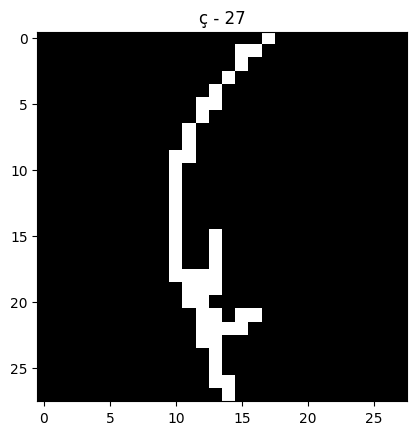

In [32]:
# Get the name of the first column
first_column_name = train.columns[0]

# Filter the DataFrame
filtered_train = train[train[first_column_name] == 27]

# Select a random row from the filtered DataFrame
random_row = filtered_train.sample()

# Convert the row to a numpy array and remove non-pixel columns if necessary
pixels = np.array(random_row.iloc[0])
pixels = pixels[1:]

# Reshape the pixels into the original dimensions of the image
image = pixels.reshape(28, 28)
image = image.T

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f"ç - {first_column_name}")
plt.show()

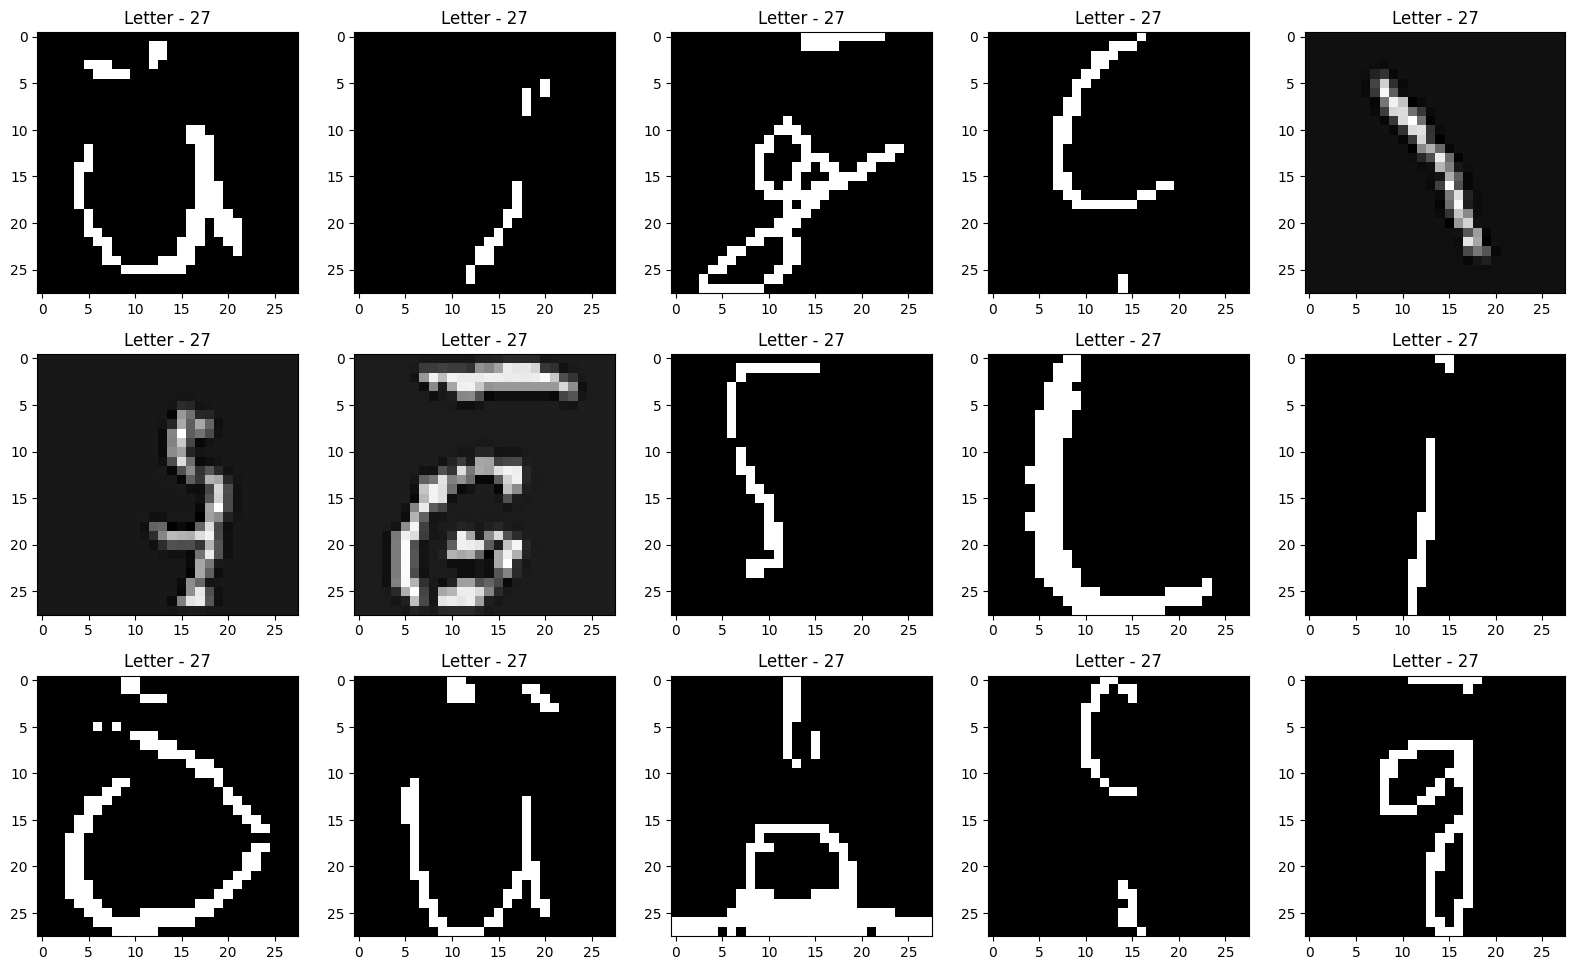

In [40]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        random_class = random.choice(classes[0])
        filtered_train = train[train[first_column_name] == random_class]
        random_row = filtered_train.sample()    
        pixels = np.array(random_row.iloc[0])
        pixels = pixels[1:]
        image = pixels.reshape(28, 28)
        image = image.T
        plt.subplot(5, 5,idx+1)
        plt.imshow(image, cmap = mono)
        plt.title(f"Letter - {random_class}")
        
    plt.tight_layout()
    
Show_example_digits()